In [5]:
%load_ext autoreload
%autoreload 2


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors

import torch
import torch as t
import torch_geometric as ptgeo

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx

from gninvert.functions import randrange, run_GN, make_color_scale, gdisplay, run_and_draw, generate_training_data, graphs_loss_func, loss_batch
from gninvert.training import fit
from gninvert.gns import MultiDiffusionGN, EquationGN
from gninvert.gnns import LinearGNN
from gninvert.graph_compare import graph_compare, model_compare

In [7]:
colorscales = [make_color_scale(-0.1, 1, plt.cm.Greys), 
             make_color_scale(-0.1, 1, plt.cm.Purples),
             make_color_scale(-0.1, 1, plt.cm.Reds)]

# Test/example

In [8]:
g_edge_index = torch.tensor(
    [[0, 1, 1, 2, 0, 2, 2, 3, 3, 4],
     [1, 0, 2, 1, 2, 0, 3, 2, 4, 3]],
    dtype=torch.long)

# g_x = torch.tensor([[0.0, 0.0, 0.4],
#                     [0.7, 0.0, 0.5],
#                     [0.4, 0.0, 0.4],
#                     [0.9, 0.0, 0.7],
#                     [0.0, 1.0, 0.5]],
#                    dtype=torch.float)

g_x = torch.tensor([[0.0, 0.0],
                    [0.7, 0.0],
                    [0.4, 0.0],
                    [0.9, 0.0],
                    [0.0, 1.0]],
                   dtype=torch.float)

g_data = ptgeo.data.Data(x=g_x, edge_index=g_edge_index)

diffusionGN = MultiDiffusionGN([0.1, 0.1])

Iteration 0
sum: 3.0 / node values:
[[0.0, 0.0], [0.699999988079071, 0.0], [0.4000000059604645, 0.0], [0.8999999761581421, 0.0], [0.0, 1.0]]


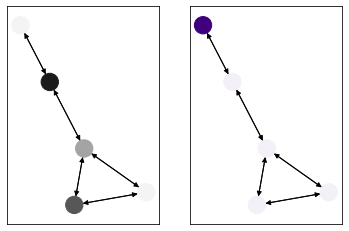

Iteration 3
sum: 3.0 / node values:
[[0.2525999844074249, 0.0010000000474974513], [0.4926999807357788, 0.0010000000474974513], [0.45729997754096985, 0.024000000208616257], [0.5900000333786011, 0.21899999678134918], [0.20740000903606415, 0.7549999952316284]]


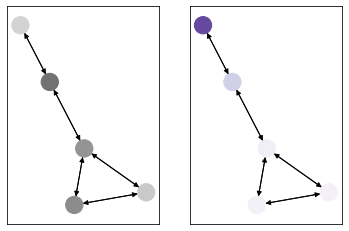

Iteration 6
sum: 3.0 / node values:
[[0.35311537981033325, 0.011494000442326069], [0.43546968698501587, 0.011494000442326069], [0.44107669591903687, 0.06626300513744354], [0.4728206992149353, 0.2921850085258484], [0.2975175082683563, 0.6185639500617981]]


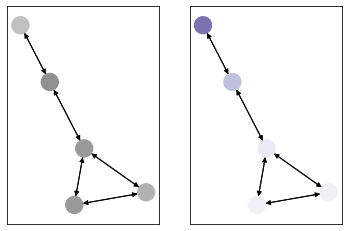

Iteration 9
sum: 3.0 / node values:
[[0.3911263644695282, 0.02957237884402275], [0.41937389969825745, 0.02957237884402275], [0.4247835874557495, 0.09713328629732132], [0.4251682460308075, 0.31110432744026184], [0.33954787254333496, 0.5326175689697266]]


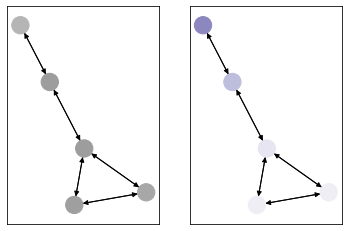

Data(x=[5, 2], edge_index=[2, 10])

In [9]:
run_and_draw(diffusionGN, g_data, 9, 3, colorscales)

# Generate training data from the simulation

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [8]:
x_train, y_train = generate_training_data(diffusionGN)

In [9]:
y_train[0] == x_train[1]

True

In [10]:
print(f"Training items: {len(x_train)}")
assert len(x_train) == len(y_train)

Training items: 200


In [11]:
train_i = round(len(x_train) * 0.75)
train_x = x_train[0:train_i]
valid_x = x_train[train_i:]
train_y = y_train[0:train_i]
valid_y = y_train[train_i:]
batch_size = 10

In [12]:
#train_ds = TensorDataset(x_train, y_train)
#train_dl = DataLoader(train_ds, batch_size=5)
# ^error: graphs are not tensors

# Train a network

In [14]:
import torch.nn.functional as F

In [36]:
# run to reset model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
perf_history = []
lr_history = []
model = LinearGNN(2).to(device)
next_graph = lambda gdata : ptgeo.data.Data(x = model(gdata),
                                            edge_index = gdata.edge_index)


In [37]:
graphs_loss_func(model, x_train[0:2], y_train[0:2])

tensor(1.6389, grad_fn=<AddBackward0>)

In [49]:
# rerun to reset optim and LR scheduler
optim = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim,
        patience=60,
        cooldown=100,
        factor=0.2
    )

  0%|          | 0/300 [00:00<?, ?it/s]

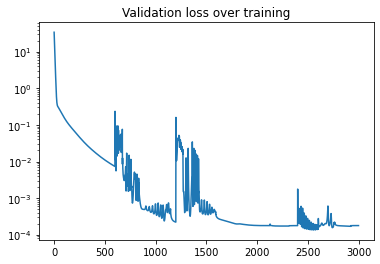

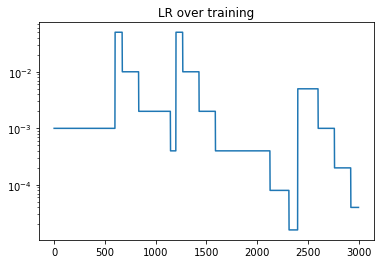

In [51]:
# rerun to continue training

(perf_history_add, lr_history_add) = fit(
    300, model, torch.nn.MSELoss(), optim, 
    (train_x, train_y),
    (valid_x, valid_y),
    lr_scheduler=scheduler,
    return_early_on_lr = 1e-8,
    progress_bar = True,
    return_lr = True
)
perf_history += perf_history_add
lr_history += lr_history_add

plt.title("Validation loss over training")
plt.plot(perf_history)
plt.yscale('log')
plt.show()

plt.title("LR over training")
plt.plot(lr_history)
plt.yscale('log')
plt.show()

In [52]:
list(model.m1.parameters())

[Parameter containing:
 tensor([[ 0.2158,  0.1242, -0.2457, -0.1464],
         [ 0.1165, -0.1833, -0.1605,  0.2557]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0229, -0.0121], requires_grad=True)]

In [53]:
list(model.u1.parameters())

[Parameter containing:
 tensor([[ 0.9645,  0.0146, -0.2908, -0.1631],
         [ 0.0178,  0.9481, -0.1654,  0.2747]], requires_grad=True),
 Parameter containing:
 tensor([0.0095, 0.0149], requires_grad=True)]

Iteration 0
sum: 3.0 / node values:
[[0.0, 0.0], [0.699999988079071, 0.0], [0.4000000059604645, 0.0], [0.8999999761581421, 0.0], [0.0, 1.0]]


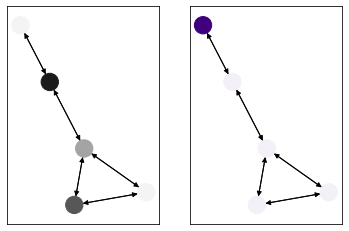

Iteration 1
sum: 3.0 / node values:
[[0.10999999940395355, 0.0], [0.5999999642372131, 0.0], [0.4399999976158142, 0.0], [0.7599999904632568, 0.10000000149011612], [0.08999999612569809, 0.8999999761581421]]


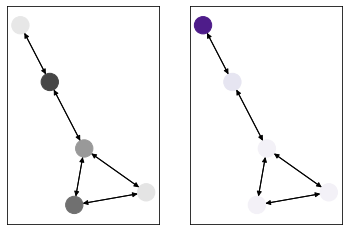

Iteration 2
sum: 3.0 / node values:
[[0.19200000166893005, 0.0], [0.5349999666213989, 0.0], [0.45499998331069946, 0.010000000707805157], [0.6610000133514404, 0.17000000178813934], [0.15700000524520874, 0.8199999928474426]]


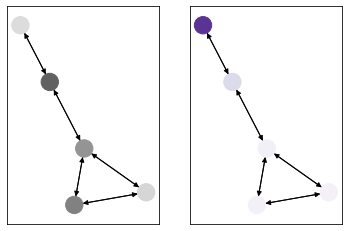

Iteration 3
sum: 3.0 / node values:
[[0.2525999844074249, 0.0010000000474974513], [0.4926999807357788, 0.0010000000474974513], [0.45729997754096985, 0.024000000208616257], [0.5900000333786011, 0.21899999678134918], [0.20740000903606415, 0.7549999952316284]]


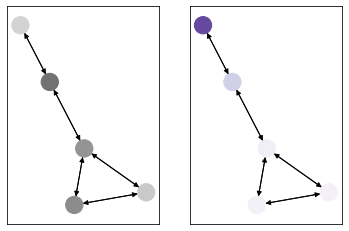

Iteration 4
sum: 3.000000238418579 / node values:
[[0.29707998037338257, 0.0032999999821186066], [0.46514996886253357, 0.0032999999821186066], [0.4536399841308594, 0.03890000283718109], [0.5384700298309326, 0.2531000077724457], [0.24566000699996948, 0.7013999819755554]]


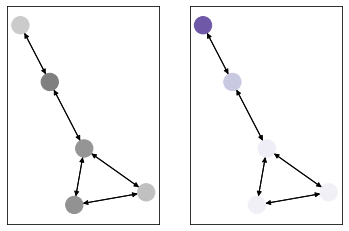

Data(x=[5, 2], edge_index=[2, 10])

In [56]:
run_and_draw(diffusionGN, g_data, 4, 1, colorscales)

Iteration 0
sum: 3.0 / node values:
[[0.0, 0.0], [0.699999988079071, 0.0], [0.4000000059604645, 0.0], [0.8999999761581421, 0.0], [0.0, 1.0]]


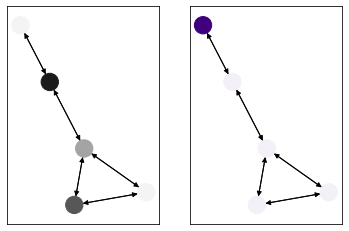

Iteration 1
sum: 2.9879612922668457 / node values:
[[0.10750093311071396, -0.003104979172348976], [0.5998580455780029, 0.006608530879020691], [0.4393031895160675, -0.009242799133062363], [0.760921061038971, 0.10313292592763901], [0.10101757198572159, 0.8819668889045715]]


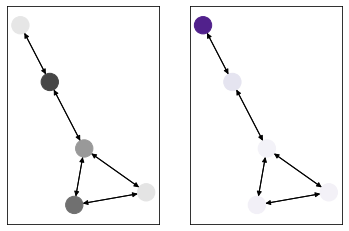

Iteration 2
sum: 2.977382183074951 / node values:
[[0.18765929341316223, -0.0045260656625032425], [0.5339795351028442, 0.00922162365168333], [0.454843670129776, -0.005252869799733162], [0.6633290648460388, 0.1723441332578659], [0.17571812868118286, 0.7900654077529907]]


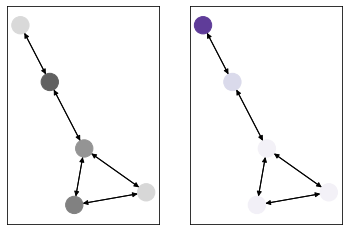

Iteration 3
sum: 2.9680469036102295 / node values:
[[0.24695350229740143, -0.004038527607917786], [0.490561306476593, 0.010554809123277664], [0.4579334259033203, 0.004721375182271004], [0.5940403938293457, 0.2185239940881729], [0.2314259260892868, 0.7173704504966736]]


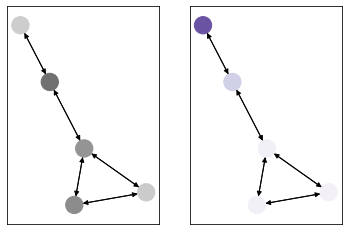

Iteration 4
sum: 2.9597694873809814 / node values:
[[0.29052120447158813, -0.0018198955804109573], [0.4618855118751526, 0.011950219981372356], [0.45494309067726135, 0.01679476723074913], [0.5443254709243774, 0.2489141821861267], [0.2732711434364319, 0.6589840054512024]]


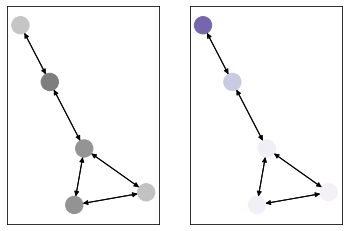

Data(x=[5, 2], edge_index=[2, 10])

In [57]:
run_and_draw(model, g_data, 4, 1, colorscales)

In [60]:
model.message(torch.tensor([[1.2, 1.3]]), torch.tensor([[1.3, 0.2]]))

tensor([[ 0.0947, -0.2680]], grad_fn=<AddmmBackward0>)

Stats for 20 steps for node features:
Greatest relative difference: 9242799.21875%
Average relative difference: 163639.94486927986%
Smallest relative difference: 100.00250339508057%
Greatest absolute difference: 0.04682314395904541
Average absolute difference: 0.015350127103738486
Smallest absolute difference: 1.0311603546142578e-05%


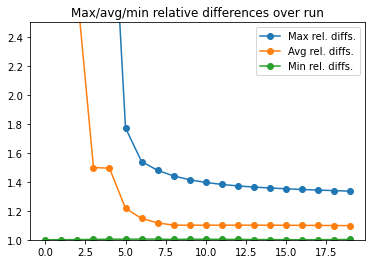

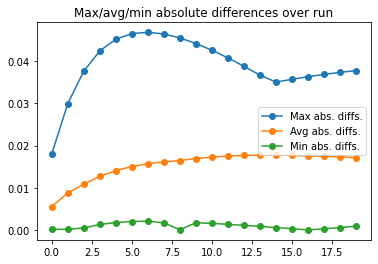

The model being tested finished the run outputting this graph:


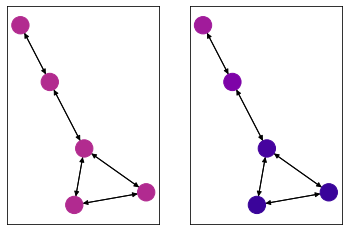

tensor([[0.3990, 0.0852],
        [0.3996, 0.0854],
        [0.4050, 0.1125],
        [0.4057, 0.2527],
        [0.4044, 0.3486]], grad_fn=<AddmmBackward0>)
The ground truth model finished the run outputting this graph:


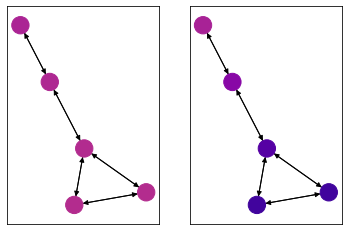

tensor([[0.4091, 0.0992],
        [0.4097, 0.0992],
        [0.4058, 0.1503],
        [0.3940, 0.2798],
        [0.3814, 0.3715]])


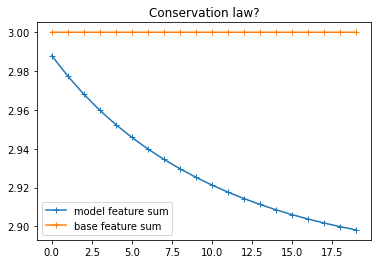

In [78]:
model_pred, sim_pred = model_compare(model, diffusionGN, g_data, iterations=20)

In [79]:
graph_compare(sim_pred, model_pred,  verbose=True, absolute=False)

Differences tensor:
tensor([[1.0252, 1.1649],
        [1.0250, 1.1612],
        [1.0022, 1.3355],
        [1.0298, 1.1074],
        [1.0603, 1.0657]], grad_fn=<CopySlices>)
Maximum relative difference: 133.55032205581665%
Average relative difference: 109.7728967666626%
Minimum relative difference: 100.2192735671997%


False

In [80]:
sim_pred.x

tensor([[0.4091, 0.0992],
        [0.4097, 0.0992],
        [0.4058, 0.1503],
        [0.3940, 0.2798],
        [0.3814, 0.3715]])

In [81]:
model_pred.x

tensor([[0.3990, 0.0852],
        [0.3996, 0.0854],
        [0.4050, 0.1125],
        [0.4057, 0.2527],
        [0.4044, 0.3486]], grad_fn=<AddmmBackward0>)

# Visualize functions

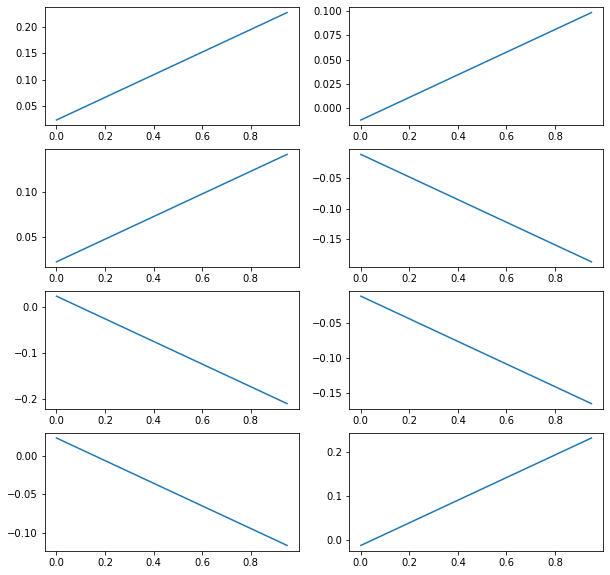

In [82]:
features = model.num_node_features
fig, ax = plt.subplots(features*2, features, figsize=(10,10))
    
for x in range(features * 2):
    for y in range(features):
        xs = torch.zeros(features*2)
        series = []
        val_range = torch.arange(0, 1, 0.05)
        for v in val_range:
            xs[x] = v
            xs_t = xs[0:features].unsqueeze(0)
            xs_s = xs[features:].unsqueeze(0)
            ys = model.message(xs_t, xs_s)
            series.append(ys[0][y].item())
        ax[x][y].plot(val_range, series)

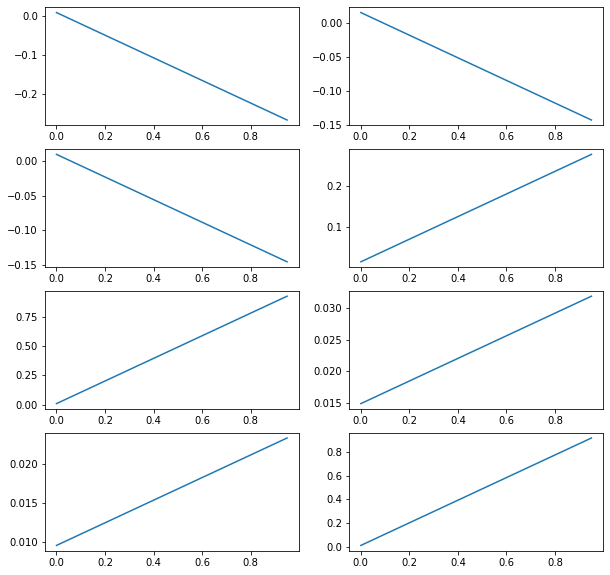

In [83]:
features = model.num_node_features
fig, ax = plt.subplots(features*2, features, figsize=(10,10))
    
for x in range(features * 2):
    for y in range(features):
        xs = torch.zeros(features*2)
        series = []
        val_range = torch.arange(0, 1, 0.05)
        for v in val_range:
            xs[x] = v
            xs_t = xs[0:features].unsqueeze(0)
            xs_s = xs[features:].unsqueeze(0)
            ys = model.update(xs_t, xs_s)
            series.append(ys[0][y].item())
        ax[x][y].plot(val_range, series)

## along y-axis: the 6 different input features
## along the x-axis: the 3 different output featuers
## graphed at [x,y]: how adjusting the yth input changes the xth output

# Symbolic regression with `gplearn`

In [21]:
from gplearn.genetic import SymbolicRegressor
from symbolic_regression import get_equations

In [22]:
model_for_sr = t.load('models/sim2-hpmodel2.pt')
# note: not using the results of the above training process but one of the
# models from the hyperparameter search

In [23]:
model_for_sr.message(t.tensor([[1., 2.], [2., 3.]]), t.tensor([[1., 4.], [5., 6.]]))

tensor([[-0.3920,  0.4602],
        [-1.6627,  0.1454]], grad_fn=<AddmmBackward0>)

In [24]:
msg_srs = get_equations(
    dimensions=[2,2],
    function=model_for_sr.message,
    n=400
)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    31.09      2.43577e+07        9         0.068174        0.0783198     50.58m
   1     6.42          2.38648        9        0.0632035        0.0643256     36.19m
   2     3.39          1.11345        9        0.0613779        0.0807557     31.81m
   3     2.88          1.50389        9        0.0627145        0.0687266     30.71m
   4     5.18          12.1009        5        0.0645217         0.094136     31.84m
   5     5.22          12.1375        5        0.0642889        0.0962312     29.46m
   6     5.22          4.77451       17        0.0572052        0.0572506     28.01m
   7     5.21          1.58571       15         0.052262        0.0460159     29.65m
   8     5.23          1.07584        5        0.0644586         0.094704  

In [25]:
print(msg_srs[0])
print(msg_srs[1])

mul(0.361, sub(sub(X0, sub(X3, X1)), X2))
mul(mul(add(X1, X1), X2), mul(mul(X1, X1), -0.100))


## A note on SR results
They're horrible; equations should be linear equations of four variables and fit very well. The above training process shows "fitness" (really the loss function result, i.e. lower = fitter) increasing rather than decreasing over the second run, and the length oscillating quite wildly, suggesting that `gplearn` is not making good progress and is not settling on a good equation structure.